# Installation of the code
requirements: Python, numpy, and a c++ compiler.<br>
download the code: <br> 
```
git clone https://github.com/haowang-astro/jetsimpy
```
install from source: <br>
```
cd jetsimpy
pip install . && python setup.py clean

```
The second "clean" command is necessary. 

Let's first define a dictionary of parameters to be used later.

In [1]:
import jetsimpy
import numpy as np
from matplotlib import pyplot as plt

P = dict(
    Eiso = 1e52,        # Isotropic equivalent energy
    lf = 300,           # Lorentz factor
    theta_c = 0.1,      # half opening angle
    n0 = 1,             # ism number density
    A = 0,              # wind number density amplitude
    eps_e = 0.1,        # epsilon_e
    eps_b = 0.01,       # epsilon_b
    p = 2.17,           # electron power index
    theta_v = 0.4,      # viewing angle (rad)
    d = 474.33,         # distance (Mpc)
    z = 0.1,            # redshift
)

## Step 1. define the jet structure.
There are some built-in jet structures in the code:<br>
A top-hat jet: `jetsimpy.TopHat(P["theta_c"], P["Eiso"], lf0=P["lf"])`<br>
A Gaussian jet: `jetsimpy.Gaussian(P["theta_c"], P["Eiso"], lf0=P["lf"])`<br>
A Power-law jet `jetsimpy.PowerLaw(P["theta_c"], P["Eiso"], lf0=P["lf"], s=4.0)`<br>
For now, let's choose the Gaussian jet.

In [2]:
theta, Eiso, lf = jetsimpy.Gaussian(P["theta_c"], P["Eiso"], lf0=P["lf"])

## Step 2. solve the hydrodynmaics of a jet

In [3]:
jet = jetsimpy.Jet(
    (theta, Eiso, lf),             # [tuple of tabulated data]: (polar angles, rest mass excluded energy, Lorentz factor)
    P["A"],                        # [wind density scale]: n = nwind * (r / 1e17)^-2 + nism (cm^-3)
    P["n0"],                       # [ism density scale]: n = nwind * (r / 1e17)^-2 + nism (cm^-3)
    tmin=10.0,                     # [simulation start time]: (s)
    tmax=3.2e9,                    # [simulation end time]: (s)
    grid=jetsimpy.NorthPole(P["theta_c"], 129),    # [cell edge angles]: must start with 0 and end with pi.
    tail=True,                     # [isotropic tail]: add an extremely low energy low velocity isotropic tail for safty
    spread=True,                   # w/wo spreading effect 
    cal_level=1,                   # [calibration level]: 0: no calibration. 1: BM all time. 2: smoothly go from BM to ST (dangerous)
    rtol=1e-6,                     # [primitive variable solver tolerance]: Don't change it unless you know what is going on.
    cfl=0.9,                       # [cfl number]: Don't change it unless you know what is going on.
)

### Some notes on the keyword arguments
1. `theta` must go from 0 to pi.
2. `Eiso` must be strictly possitive.
3. `lf` must be strictly larger than 1.
4. `tmin` is the start time. The jet will initially coast from t=0 to this time.
5. `grid` is an 1D `np.array` of cell "edge" positions. It must start form 0 and end with pi.
6. `tail` is an option to add an isotropic tail with low energy and low speed. The purpose of is parameter is to make sure Eiso>0 and lf>1, which is important for the code to work properly. If you are 100% confident of your initial jet profile, you can turn off this option.
7. `cal_level` is the level of calibration. 0: no calibration. 1: Blandford-McKee. 2: smoothly go from Blandford-McKee to Sedov-Taylor. The default option is `cal_level=1`. Note that `cal_level=2` may be dangerous, because in Newtonian limit the shell is not thin, and the calibration may not make sense.
8. `rtol` and `cfl` are the parameters you should not change.

## Step 2. Calculate the afterglow observables
### Flux density

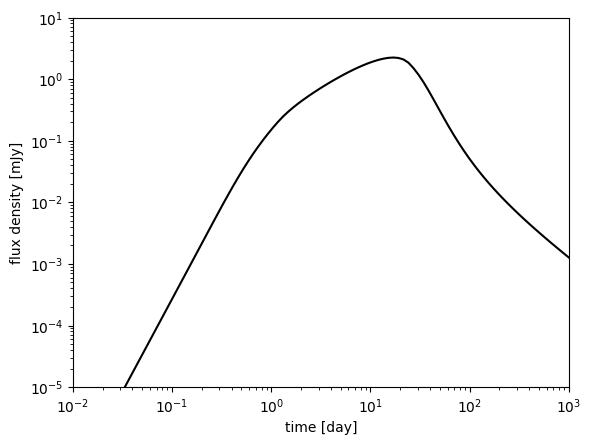

In [4]:
# define the observing time and frequency
tday = np.logspace(-2, 3, 100)
tsecond = tday * 3600 * 24
nu = 3e9

# calculate the afterglow flux density (unit: mJy)
flux = jet.FluxDensity(
    tsecond,           # [second] observing time span
    nu,                # [Hz]     observing frequency
    P,                 # parameter dictionary
    model="sync",      # emissivity model
    rtol=1e-3,         # integration tolerance
)

# plot the light curves
plt.plot(tday, flux, color="black")
plt.xlim(1e-2, 1e3)
plt.ylim(1e-5, 1e1)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("time [day]")
plt.ylabel("flux density [mJy]")
plt.show()

### Some notes on the keyword arguments
1. The parameter distionary `P` must be compatible with radiation model `model`. Namely, the parameters used in the `model` (defined in a C++ source file) must be specified in `P`. Moreover, three parameters must be specified no matter what model you are using: `theta_v` the observing angle, `d` the luminosity distance, and `z` the redshift.
2. `model` is a string referring to a radiation model defined in a C++ file to be explained later. The default model is `model='sync'` which is the standard synchrotron radiation model without self-absorption. The necessary parameters to be used in `model='sync'` are `eps_e`, `eps_b`, and `p`.
3. `rtol` is the integral tolerance. Default value is `rtol=1e-3`.

### Apparent superluminal motion

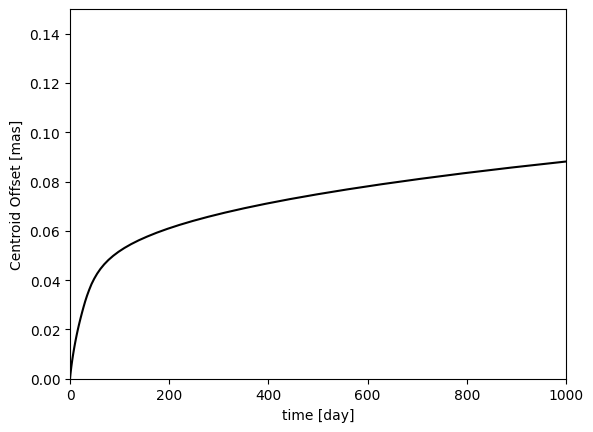

In [5]:
offset = jet.Offset(
    tsecond,           # [second] observing time span
    nu,                # [Hz]     observing frequency
    P,                 # parameter dictionary for radiation
)

plt.plot(tday, offset, color="black")
plt.xlim(0, 1e3)
plt.ylim(0, 0.15)
plt.xlabel("time [day]")
plt.ylabel("Centroid Offset [mas]")
plt.show()

### image size

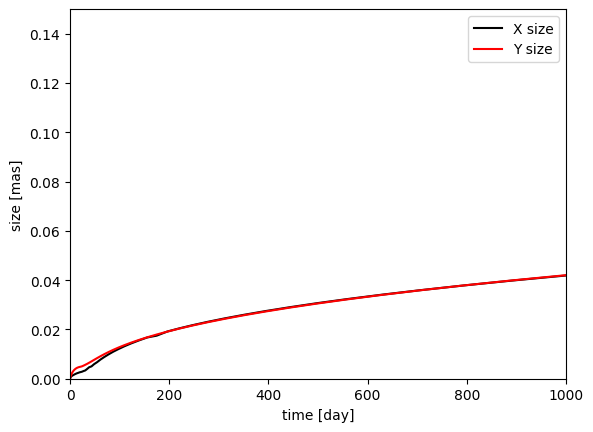

In [6]:
# X direction is along the jet axis.
x_size = jet.SizeX(
    tsecond,           # [second] observing time span
    nu,                # [Hz]     observing frequency
    P,                 # parameter dictionary for radiation
)

# Y direction is perpendicular to the jet axis
y_size = jet.SizeY(
    tsecond,           # [second] observing time span
    nu,                # [Hz]     observing frequency
    P,                 # parameter dictionary for radiation
)

plt.plot(tday, x_size, color="black", label="X size")
plt.plot(tday, y_size, color="red", label="Y size")
plt.xlim(0, 1e3)
plt.ylim(0, 0.15)
plt.xlabel("time [day]")
plt.ylabel("size [mas]")
plt.legend()
plt.show()

### sky map

In [7]:
# time and frequency of sky map
tday = 10
nu = 3e9
tsecond = tday * 3600 * 24

# make an image with half width: (centroid + 3 * size_x) [unit: mas],
# such that the whole jet is visible in the image
offset = jet.Offset(tsecond, nu, P)
size_x = jet.SizeX(tsecond, nu, P)
size_y = jet.SizeY(tsecond, nu, P)
half_width = offset + 3 * size_x

# intensity map data matrix: resolution 300 x 300
resolution = 300
x_tilde = np.linspace(- half_width, half_width, resolution)    # x pixel coordinates
y_tilde = np.linspace(- half_width, half_width, resolution)    # y pixel coordinates
X, Y = np.meshgrid(x_tilde, y_tilde)
sky_map = jet.IntensityOfPixel(tsecond, nu, X, Y, P)

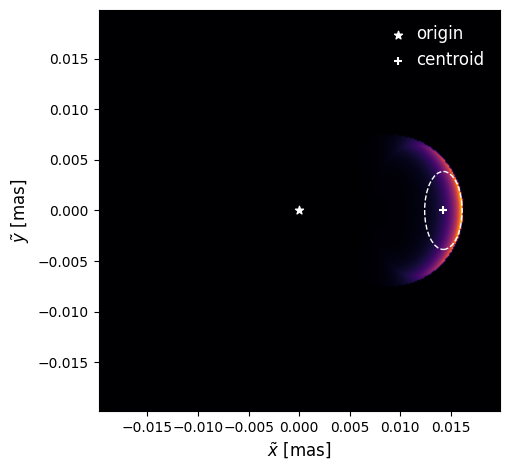

In [8]:
from matplotlib.patches import Ellipse
# configurate the plot
fig, ax = plt.subplots()
Inorm = sky_map / sky_map.max()    # normalize to 1
Inorm = np.rot90(Inorm, 2)         # rotate to align the plt.imshow() extent
im = ax.imshow(Inorm, interpolation='gaussian', cmap="inferno", extent=[-half_width, half_width, -half_width, half_width])
im.set_clim(vmin=0.0, vmax=1.0)

# plot the origin, centroid, and [optional] size contour just for fun! (you are welcome to uncomment the line below.)
ax.scatter(0, 0, marker="*", color="white", label="origin")
ax.scatter(offset, 0.0, marker="+", color="white", label="centroid")
ax.add_patch(Ellipse((offset, 0), size_x * 2, size_y * 2, edgecolor="white", fill=False, linestyle="--", linewidth=1))

# show the image!
ax.set_xlabel(r"$\tilde{x}$ [mas]", fontsize=12)
ax.set_ylabel(r"$\tilde{y}$ [mas]", fontsize=12)
ax.legend(loc="upper right", frameon=False, labelcolor="white", fontsize=12, handletextpad=0.1)
fig.tight_layout()
plt.show()

## Access the hydrodynamic results
1. `jet.dE0_dOmega(t, theta)`. Rest mass excluded angular energy profile.
2. `jet.dMsw_dOmega(t, theta)`. Swept-up mass angular profile.
3. `jet.dMej_dOmega(t, theta)`. ejecta mass angular profile.
4. `jet.beta_gamma(t, theta)`. 4-velocity angular profile.
5. `jet.beta_theta(t, theta)`. tangent velocity angular profile.
6. `jet.R(t, theta)`. Radius angular profile.

In [12]:
# generate data
t = 100 * 3600 * 24
theta = np.linspace(0, np.pi, 1000)
dE_dOmega = jet.dE0_dOmega(t, theta)
beta_gamma = jet.beta_gamma(t, theta)

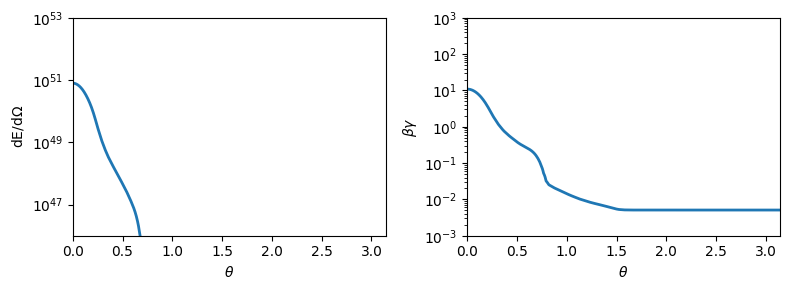

In [13]:
from matplotlib import animation

# configure the canvas
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].plot(theta, dE_dOmega, lw=2)
axes[0].set_yscale("log")
axes[0].set_ylim(1e46, 1e53)
axes[0].set_xlim(0, np.pi)
axes[0].set_xlabel(r"$\theta$")
axes[0].set_ylabel(r"dE/d$\Omega$")

axes[1].plot(theta, beta_gamma, lw=2)
axes[1].set_yscale("log")
axes[1].set_ylim(1e-3, 1e3)
axes[1].set_xlim(0, np.pi)
axes[1].set_xlabel(r"$\theta$")
axes[1].set_ylabel(r"$\beta\gamma$")
fig.tight_layout()